In [25]:
import torch
import torchvision
import torchvision.transforms as transforms

# Dataset

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))])

batch_size = 128
epochs = 20

# Load datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Print images from dataset and their labels

torch.Size([128, 1, 28, 28]) torch.Size([128])


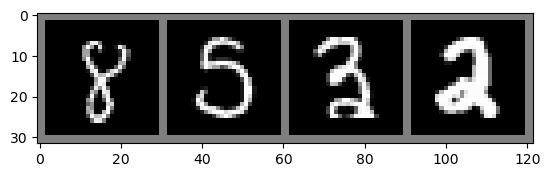

8 5 3 2


In [27]:
import matplotlib.pyplot as plt
from utils import imshow

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

# LeNet-300-100

In [28]:
from models.lenet import LeNet300

net = LeNet300(10)
# Try to get GPU device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

cuda:0


LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [29]:
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as sched
from train import MyMultiStepLR

loss_fn = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=1e-3,momentum=0.9)



In [30]:
from torch.utils.tensorboard import SummaryWriter
from train import training_loop

writer = SummaryWriter('runs/mnist_lenet-300-100')

loss, train_acc, val_acc = training_loop(epochs,net,optimizer,device,trainloader,testloader,loss_fn,100,
                                         None,'checkpoints/mnist_lenet300.pth',writer)



***Epoch: 001/020 | Batch:0000/0469 | Loss: 2.299
***Epoch: 001/020 | Batch:0100/0469 | Loss: 2.137
***Epoch: 001/020 | Batch:0200/0469 | Loss: 1.784
***Epoch: 001/020 | Batch:0300/0469 | Loss: 1.189
***Epoch: 001/020 | Batch:0400/0469 | Loss: 0.804
***Epoch: 001/020 | Train. Acc.: 81.887% | Loss: 0.734
Epoch: 001/020 | Train accuracy: 81.89% | Validation accuracy: 82.75% | Train loss: 0.734| Validation loss: 0.716| Best Validation (Ep. 000): -inf%
Time elapsed: 0.27 min
***Epoch: 002/020 | Batch:0000/0469 | Loss: 0.746
***Epoch: 002/020 | Batch:0100/0469 | Loss: 0.670
***Epoch: 002/020 | Batch:0200/0469 | Loss: 0.519
***Epoch: 002/020 | Batch:0300/0469 | Loss: 0.441
***Epoch: 002/020 | Batch:0400/0469 | Loss: 0.481
***Epoch: 002/020 | Train. Acc.: 87.855% | Loss: 0.434
Epoch: 002/020 | Train accuracy: 87.85% | Validation accuracy: 88.47% | Train loss: 0.434| Validation loss: 0.418| Best Validation (Ep. 001): 82.75%
Time elapsed: 0.55 min
***Epoch: 003/020 | Batch:0000/0469 | Loss: 0.3

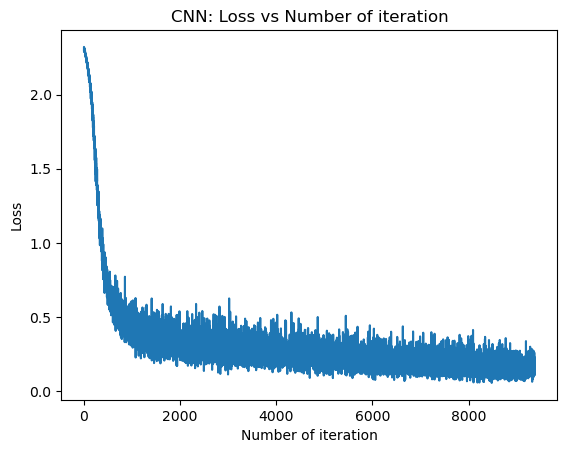

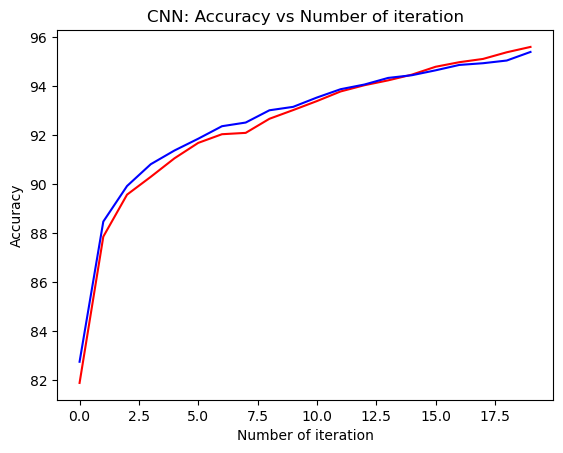

In [31]:
# visualization loss
plt.plot(loss)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(train_acc,color = "red")
plt.plot(val_acc,color = "blue")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

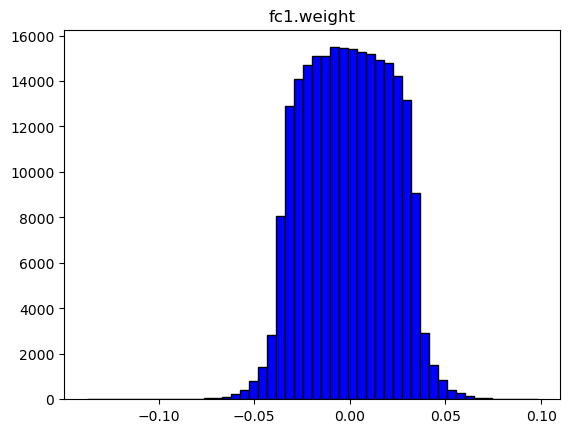

fc1.weight | std: 0.022


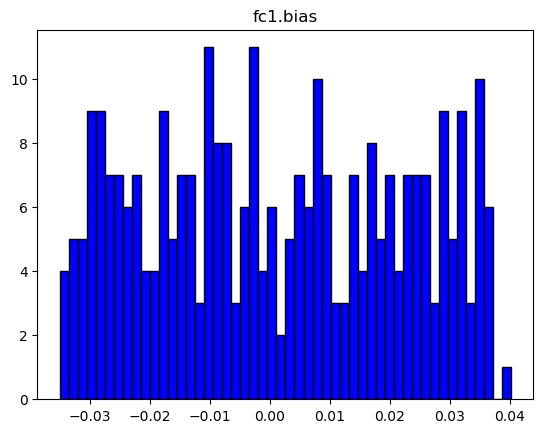

fc1.bias | std: 0.021


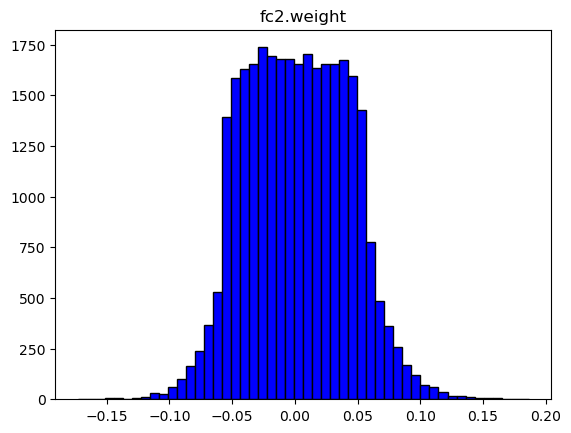

fc2.weight | std: 0.041


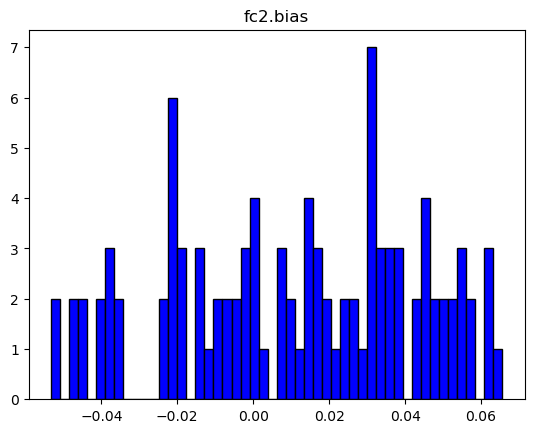

fc2.bias | std: 0.032


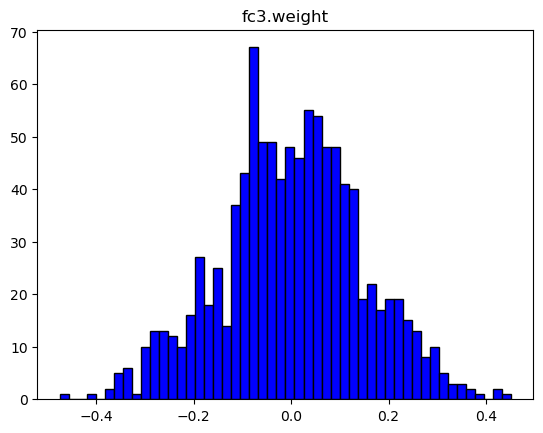

fc3.weight | std: 0.145


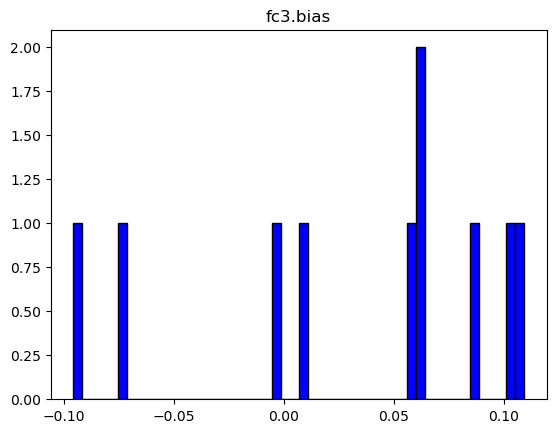

fc3.bias | std: 0.071


In [154]:
import torch.nn.utils.prune as prune

net = LeNet300(10)
net.load_state_dict(torch.load('checkpoints/mnist_lenet300.pth'))
stds = {}

for name, param in net.named_parameters():
    t = param.data.cpu().view(1,-1)
    _ = plt.hist(t, color = 'blue', edgecolor = 'black',bins=50)
    plt.title(name)
    plt.show()
    print('%s | std: %.3f'%(name,torch.std(t)))
    stds[name] = torch.std(t)

# print(net.state_dict().keys())
# module = net.fc1
#
# w0 = list(module.named_parameters())[0][1].data
# _ = plt.hist(w0.view(1,-1), color = 'blue', edgecolor = 'black',
#          bins = int(30))
#
# print(torch.std(w0))
#
# plt.show()
#
# module = net.fc2
#
# w1 = list(module.named_parameters())[0][1].data
# _ = plt.hist(w1.view(1,-1), color = 'blue', edgecolor = 'black',
#          bins = int(30))
#
# plt.show()

In [155]:
s = 2
import numpy as np
from torch.nn.utils import prune

class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        return torch.abs(tensor) > self.threshold

for name, module in net.named_modules():
    if name in ['fc1','fc2','fc3']:
        threshold = np.std(module.weight.data.cpu().numpy()) * s
        print('Pruning with threshold : %.3f for layer %s'%(threshold,name))
        # calculate pruned weights
        prune.global_unstructured([(module,"weight")],pruning_method=ThresholdPruning,threshold=threshold)
        # apply the pruning
        prune.remove(module, 'weight')

Pruning with threshold : 0.045 for layer fc1
Pruning with threshold : 0.082 for layer fc2
Pruning with threshold : 0.290 for layer fc3


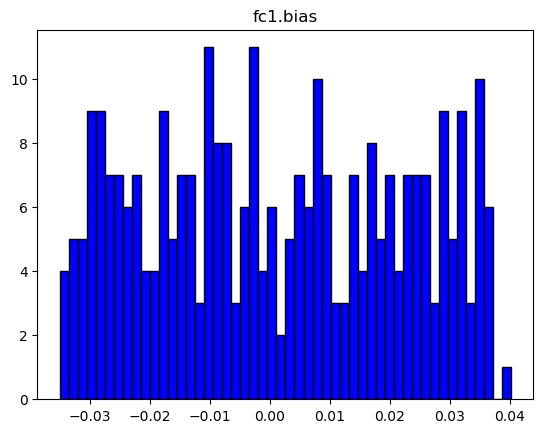

fc1.bias | std: 0.021


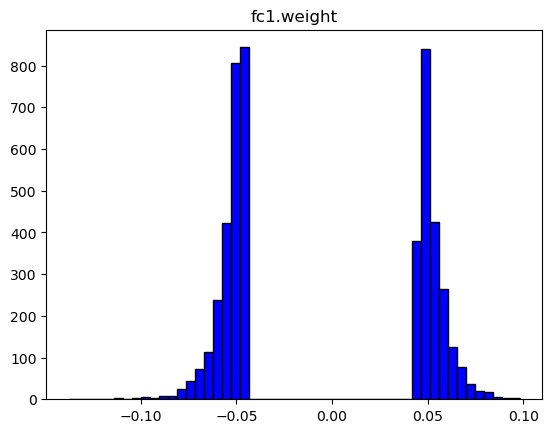

fc1.weight | std: 0.053


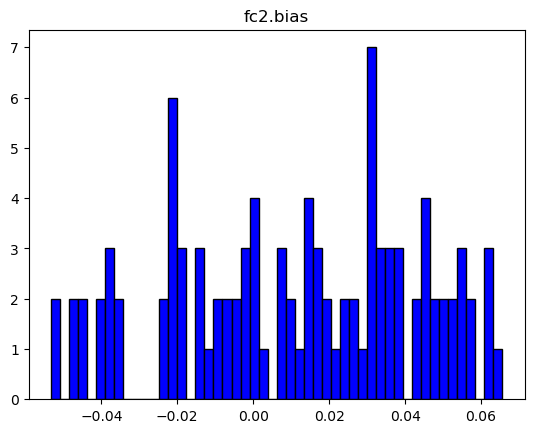

fc2.bias | std: 0.032


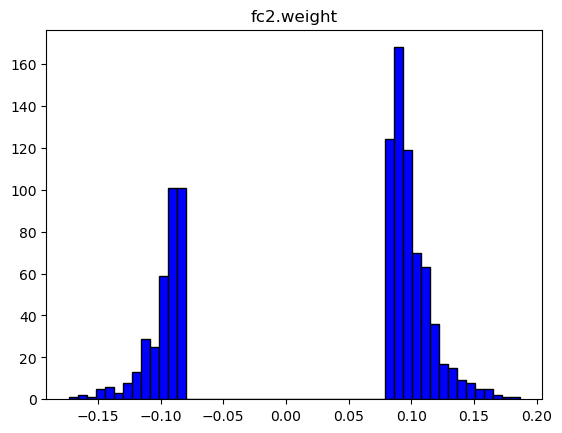

fc2.weight | std: 0.096


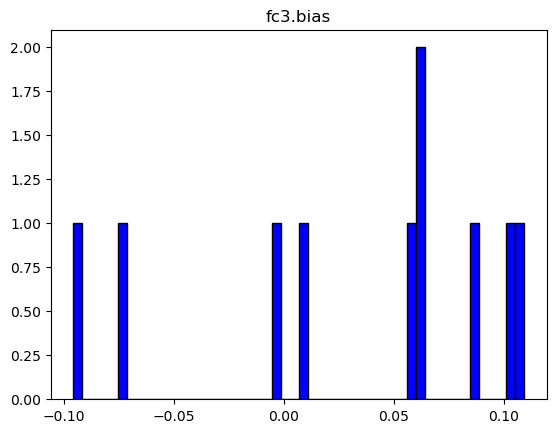

fc3.bias | std: 0.071


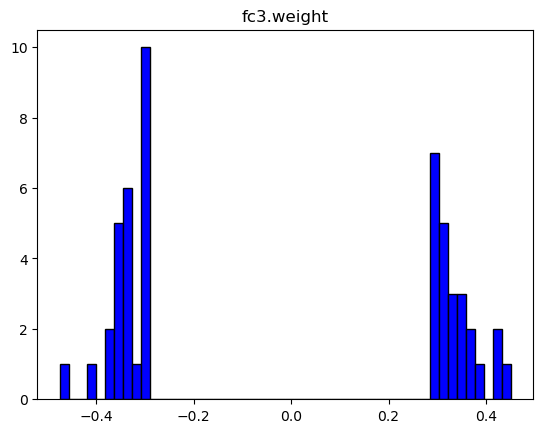

fc3.weight | std: 0.341


In [156]:
for name, param in net.named_parameters():
    t = param.data.cpu().view(1,-1)
    t = t[t!=0]
    _ = plt.hist(t, color = 'blue', edgecolor = 'black',bins=50)
    plt.title(name)
    plt.show()
    print('%s | std: %.3f'%(name,torch.std(t)))
    stds[name] = torch.std(t)

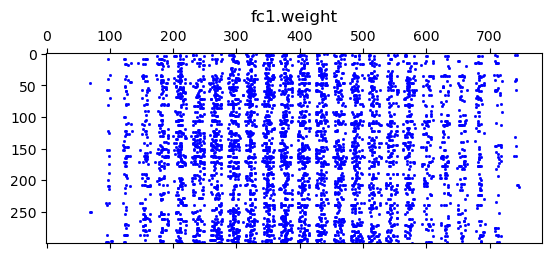

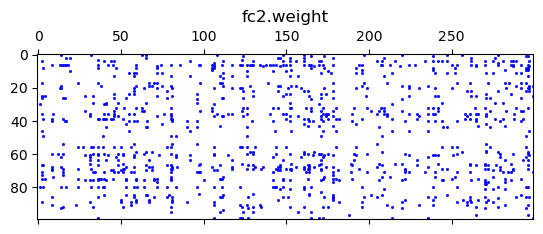

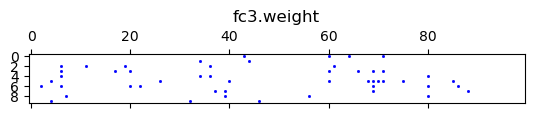

In [157]:
for name, param in net.named_parameters():
    if name in ['fc1.weight','fc2.weight','fc3.weight']:
        t = param.data.cpu()
        _ = plt.spy(t,color='blue',markersize=1)
        plt.title(name)
        plt.show()

In [158]:
torch.save(net.state_dict(), 'checkpoints/mnist_lenet300_pruned.pth')

# LeNet-5

Images need to be rescaled to size 32x32 as described in LeCun et al. 1998

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5)),
     transforms.Resize(32)])
# Load datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

torch.Size([128, 1, 32, 32]) torch.Size([128])


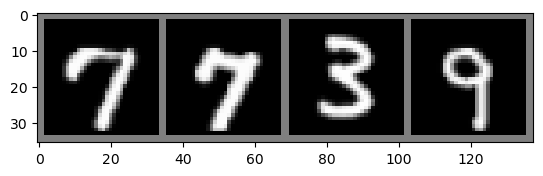

7 7 3 9


In [34]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

In [35]:
from models.lenet import LeNet5

net = LeNet5(10)
# Try to get GPU device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

cuda:0


LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [36]:
from train import training_loop

loss_fn = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=1)

lrs = MyMultiStepLR({0:5e-4,2:2e-4,5:1e-4,8:5e-5,12:1e-5})
scheduler = sched.LambdaLR(optimizer,  lrs.get_lr,last_epoch=-1,verbose=True)

writer = SummaryWriter('runs/mnist_lenet-5')

loss, train_acc, val_acc = training_loop(epochs,net,optimizer,device,trainloader,testloader,loss_fn,100
                                         ,'checkpoints/mnist_lenet5.pth',writer)

Adjusting learning rate of group 0 to 5.0000e-04.


KeyboardInterrupt: 

In [ ]:
# visualization loss
plt.plot(loss)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(train_acc,color = "red")
plt.plot(val_acc,color = "blue")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()